# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
# %pylab inline
# pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
# from bess import PdasLm
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

# from rad import AnomalyDetection_RPCA

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
uref = sio.loadmat('../Datasets/burgers.mat')['usol'].real
data = sio.loadmat('../DeepHPMs/Matlab/burgers_sim_acc4.mat')
u = (data['usol']).real
x = data['x'].flatten()
t = data['t'].flatten()
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
# ((uref-u)**2).mean()

cmap = viridis


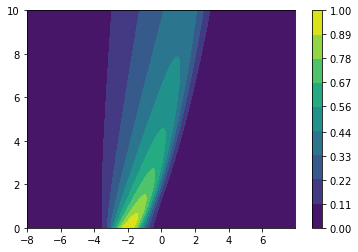

In [3]:
from matplotlib import cm
cmap_name = cm.get_cmap().name
print("cmap =", cmap_name)
levels = np.linspace(u.min(), u.max(), 10)
plt.contourf(X, T, u.T, levels)
plt.colorbar(ticks=np.round(levels, 2))
plt.show()

In [4]:
# fig = figure()
# ax = fig.gca(projection='3d')
# ax.set_zlabel("$u$", fontsize=20)
# ax.set_xlabel("$x$", fontsize=20)
# ax.set_ylabel("$t$", fontsize=20)
# surf = ax.plot_surface(X, T, u.T, 
#                        rstride=1, cstride=1, cmap=cmap_name, 
#                        linewidth=1, antialiased=False)
# # plt.title("Burgers' PDE", fontsize=20)
# # plt.savefig(fname=join_path(FIGURE_EXPORT_PATH, "burgers3d.png"), dpi=300)
# plt.show()

In [5]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.6123251953125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
# K = 2000 experiments
# weak lib only can tolerate up to 75 (maybe more?)
# weak lib + KalmanDiff: 90 (maybe more?)
# weak lib + KalmanDiff + Robust PCA: 110
# set np.random.seed(0) to reproduce...
np.random.seed(0)
noise_lv = float(1)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

1.0


(-4.3590043177412805e-06,
 0.0017980222836213628,
 0.00695094324311933,
 -0.00806627895128406)

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real

In [10]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 2.3415380859375
PDE derived using STRidge
u_t = (-1.007779 +0.000000i)uu_{x}
    + (0.103338 +0.000000i)u_{xx}
   
